In [5]:
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import json
import os

font = {'size': 16}

matplotlib.rc('font', **font)

In [6]:
def dump_dir(dir: str, path: str):
    with open(path, "w") as f:
        json.dump(dir, f, indent=4)

In [7]:
class Simulator:
    def __init__(self, workload: np.ndarray, capacity_per_pod: float, sla: float, fluctuation: float, t_cooldown: int = 1) -> None:
        self.t = 0
        self.sla = sla
        self.upper_sla = sla+fluctuation
        self.lower_sla = sla-fluctuation
        self.workload = workload
        self.capaciy_per_pod = capacity_per_pod
        self.t_cooldown = t_cooldown
        self.r_cpu_list = []
        self.n_pod_list = []
        self.n_scale = 0
        self.workload_list = []

    def run(self):
        n_pod = int(np.ceil(self.workload[0]/(self.sla*self.capaciy_per_pod)))
        t_last_scale = -1
        while self.t < len(self.workload)-2:
            current_workload = self.workload[self.t]
            self.workload_list.append(current_workload)
            r_cpu = 1.0*current_workload/(n_pod*self.capaciy_per_pod)
            self.n_pod_list.append(n_pod)
            self.r_cpu_list.append(r_cpu)
            if self.t-t_last_scale > self.t_cooldown:
                if r_cpu/self.sla>0.1:
                    target_n_pod = int(np.ceil(n_pod*(r_cpu/self.sla)))
                    if target_n_pod != n_pod:
                        n_pod = target_n_pod
                        t_last_scale = self.t
                        self.n_scale += 1
            self.t += 1

    def r_sla_violate(self):
        return 1.0*(len(np.where(np.array(self.r_cpu_list) > self.upper_sla)[0])+len(np.where(np.array(self.r_cpu_list) < self.lower_sla)[0]))/len(self.r_cpu_list)
    
    def r_sla_violate_upper(self):
        return 1.0*(len(np.where(np.array(self.r_cpu_list) > self.upper_sla)[0]))/len(self.r_cpu_list)
    
    def r_sla_violate_lower(self):
        return 1.0*(len(np.where(np.array(self.r_cpu_list) < self.lower_sla)[0]))/len(self.r_cpu_list)

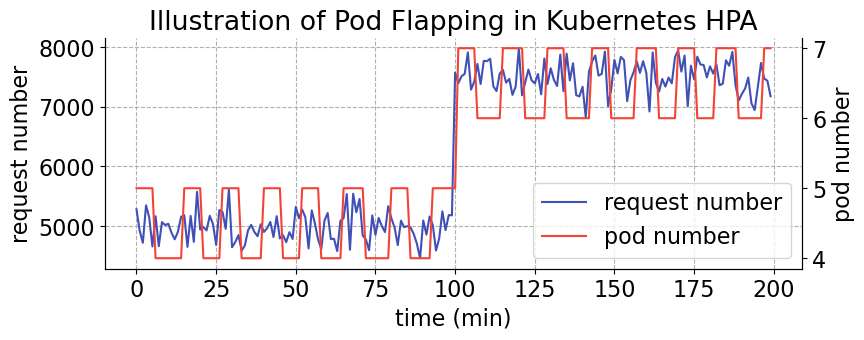

In [8]:
workload_1 = np.random.normal(5000, 250, 100)
workload_3 = np.random.normal(7500, 250, 102)
workload = np.concatenate([workload_1, workload_3])

simulator = Simulator(workload, capacity_per_pod=2500, sla=0.5, fluctuation=0.1, t_cooldown=5)
simulator.run()

fig, ax1 = plt.subplots()
fig.set_size_inches(9, 3)
xrange = np.arange(len(simulator.workload_list))
optimal = np.zeros(len(simulator.workload_list))
optimal[:len(simulator.workload_list)//2] = 5
optimal[len(simulator.workload_list)//2:] = 7

color_workload = "#3F51B5"  # material indigo
color_n_pod = "#F44336"  # material red
color_optimal = "#4CAF50"  # material green

line_workload, = ax1.plot(xrange, simulator.workload_list, color=color_workload, label="request number")
ax1.set_xlabel('time (min)')
ax1.set_ylabel('request number')

ax1.grid(True, linestyle="--")

ax2 = ax1.twinx()
line_n_pod, = ax2.plot(xrange, simulator.n_pod_list, color=color_n_pod, label="pod number")
# line_optimal, = ax2.plot(xrange, optimal, color=color_optimal, label="optimal_num_pod")


ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("pod number")

lines = [line_workload, line_n_pod]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower right')

ax1.set_title("Illustration of Pod Flapping in Kubernetes HPA")
if not os.path.exists("flapping_example"):
    os.makedirs("flapping_example")
fig.savefig("flapping_example/flapping_example.pdf")